<a href="https://colab.research.google.com/github/Riky2014/NAPDE/blob/main/cerchi_sensitivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [1]:
%%capture
!pip install -U "monai-weekly[fire, nibabel, yaml, tqdm, einops]"

# Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import and set directory

In [3]:
import os
import time
import torch
import tempfile
import numpy as np
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from nibabel import load, save, Nifti1Image

import monai
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.utils import set_determinism
from monai.networks.nets import SegResNet
from monai.data import DataLoader, decollate_batch, create_test_image_2d

from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)


directory_path = '/content/drive/MyDrive/prova_cerchi_dir'
os.environ["MONAI_DATA_DIRECTORY"] = directory_path
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

# Function definition

In [4]:
def create_image_2d (n_train, n_test, noise, r_min, r_max):

  for i in range(n_train + n_test):
    image, label = create_test_image_2d(128, 128, num_seg_classes = 1, noise_max = noise, rad_min = r_min, rad_max = r_max)
    Image.fromarray((image * 255).astype("uint8")).save(os.path.join(root_dir, f"image{i:d}.png"))
    Image.fromarray((label * 255).astype("uint8")).save(os.path.join(root_dir, f"label{i:d}.png"))

  set_determinism(seed=0)

  images = sorted(glob(os.path.join(root_dir, "image*.png")))
  labels = sorted(glob(os.path.join(root_dir, "label*.png")))
  train_files = [{"image": image, "label": label} for image, label in zip(images[:n_train], labels[:n_train])]
  val_files = [{"image": image, "label": label} for image, label in zip(images[-n_test:], labels[-n_test:])]

  return train_files, val_files

In [5]:
def transform(train_files, val_files):
  train_transform = Compose([
      LoadImaged(keys=["image", "label"]),
      EnsureChannelFirstd(keys=["image","label"]),
      EnsureTyped(keys=["image", "label"]),
      Orientationd(keys=["image", "label"], axcodes="RA"),
      Spacingd(
          keys=["image", "label"],
          pixdim=(1.0, 1.0),
          mode=("bilinear", "nearest"),
      ),
      RandSpatialCropd(keys=["image", "label"], roi_size=[128, 128], random_size=False),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      NormalizeIntensityd(keys="label", divisor= 255.0),
      RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
      RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
  ])

  val_transform = Compose([
      LoadImaged(keys=["image", "label"]),
      EnsureChannelFirstd(keys=["image","label"]),
      EnsureTyped(keys=["image", "label"]),
      Orientationd(keys=["image", "label"], axcodes="RA"),
      Spacingd(
          keys=["image", "label"],
          pixdim=(1.0, 1.0),
          mode=("bilinear", "nearest"),
      ),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      NormalizeIntensityd(keys="label", divisor= 255.0),
  ])

  train_ds = monai.data.Dataset(data=train_files, transform=train_transform)
  train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)

  val_ds = monai.data.Dataset(data=val_files, transform=val_transform)
  val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

  return train_loader, val_loader, val_ds

In [6]:
def model_and_train(train_loader, val_loader, max_epochs, val_ds):
  val_interval = 1
  VAL_AMP = True

  device = torch.device("cuda:0")
  model = SegResNet(
    spatial_dims = 2,
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=1,
    out_channels=1,
    dropout_prob=0.2,
  ).to(device)

  loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
  optimizer = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-6)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

  dice_metric = DiceMetric(include_background=True, reduction="mean")
  dice_metric_train = DiceMetric(include_background=True, reduction="mean")

  post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

  scaler = torch.cuda.amp.GradScaler()
  torch.backends.cudnn.benchmark = True

  epoch_loss_values = []
  metric_values = []
  metric_values_train = []
  total_start = time.time()

  for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = ( batch_data["image"].to(device), batch_data["label"].to(device) )
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

        outputs = [post_trans(i) for i in decollate_batch(outputs)]
        labels  = [post_trans(i) for i in decollate_batch(labels)]
        dice_metric_train(y_pred=outputs, y=labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    metric_train = dice_metric_train.aggregate().item()
    metric_values_train.append(metric_train)
    dice_metric_train.reset()

    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Loss: {epoch_loss:.4f} \nTrain dice: {metric_train:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (val_data["image"].to(device),val_data["label"].to(device))

                val_outputs = model(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                val_labels  = [post_trans(i) for i in decollate_batch(val_labels)]

                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            print(f"Test dice: {metric:.4f}")

    print(f"Time: {(time.time() - epoch_start):.4f}")
  total_time = time.time() - total_start
  print(f"Train completed, total time: {total_time}.")
  print()
  print(f"Train metric = {metric_values_train[-1]}, Test metric = {metric_values[-1]}")
  print()
  print()

  model.eval()
  with torch.no_grad():
    i = 0

    val_input = val_ds[i]["image"].unsqueeze(0).to(device)

    val_outputs = model(val_input)
    val_outputs = post_trans(val_outputs[0])

    plt.figure("fig")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.set_title("Image")
    ax1.imshow(val_ds[i]["image"][0, :, :].detach().cpu(), cmap="gray")

    ax2.set_title("Label")
    ax2.imshow(val_ds[i]["label"][0, :, :].detach().cpu())

    ax3.set_title("Output")
    ax3.imshow(val_outputs[0, :, :].detach().cpu())

    plt.show()

  return metric_values_train[-1], metric_values[-1], epoch_loss_values[-1]

In [7]:
def plot_train_dim(n_train_vec, metric_train, metric_test, loss, r_min, r_max, noise, max_epochs):
  fig, ax = plt.subplots(1, 2, figsize = (12,6))

  plt.subplot(1,2,1)
  plt.plot(n_train_vec, metric_train, label = 'Train metric')
  plt.plot(n_train_vec, metric_test, label = 'Test metric')
  plt.xscale('log', base = 2)
  plt.xlabel("Train dimention")
  plt.title(f"noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(n_train_vec, loss, label = 'Train loss')
  plt.xscale('log', base = 2)
  plt.xlabel("Train dimention")
  plt.title(f"noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

In [8]:
def plot_noise(noise_vec, metric_train, metric_test, loss, r_min, r_max, max_epochs):
  fig, ax = plt.subplots(1, 2, figsize = (12,6))

  plt.subplot(1,2,1)
  plt.plot(noise_vec, metric_train, label = 'Train metric')
  plt.plot(noise_vec, metric_test, label = 'Test metric')
  plt.xlabel("Noise")
  plt.title(f"epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(noise_vec, loss, label = 'Train loss')
  plt.xlabel("Noise")
  plt.title(f"epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

In [9]:
def delete_image(directory_path):
  file_list = os.listdir(directory_path)
  for file in file_list:
      file_path = os.path.join(directory_path, file)
      if os.path.isfile(file_path):
          os.remove(file_path)
      elif os.path.isdir(file_path):
          os.rmdir(file_path)
  print()

# Execute training
Specify:
- minimum radius ("r_min": int)
- maximum radius ("r_max": int)
- noise to be added ("noise": float)
- training epochs ("max_epochs": int)

## Dimention train samples

In [ ]:
n_train_vec  = [8, 16, 32, 64, 128, 256]
n_test = 40

noise = 0
r_min = 3
r_max = 6

max_epochs = 2

metric_values_train_vec = []
metric_values_vec = []
epoch_loss_values_vec = []


for n_train in n_train_vec:
  print()
  print(f"Number of training images = {n_train}")
  print(f"Number of testing images = {n_test}")
  print()

  train_files, val_files = create_image_2d(n_train, n_test, noise, r_min, r_max)
  train_loader, val_loader, val_ds = transform(train_files, val_files)

  metric_value_train, metric_value, epoch_loss_value = model_and_train(train_loader, val_loader, max_epochs, val_ds)

  metric_values_train_vec.append(metric_value_train)
  metric_values_vec.append(metric_value)
  epoch_loss_values_vec.append(epoch_loss_value)

  delete_image(directory_path)

plot_train_dim(n_train_vec, metric_values_train_vec, metric_values_vec, epoch_loss_values_vec, r_min, r_max, noise, max_epochs)

## Noise


Noise = 0

----------
epoch 1/2
Loss: 0.8680 
Train dice: 0.4210
Test dice: 0.5962
Time: 3.4989
----------
epoch 2/2
Loss: 0.7213 
Train dice: 0.6389
Test dice: 0.7160
Time: 3.6930
Train completed, total time: 7.192152261734009.

Train metric = 0.6388821601867676, Test metric = 0.7159836888313293




<Figure size 640x480 with 0 Axes>

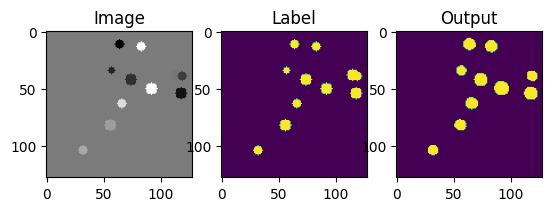



Noise = 0.3

----------
epoch 1/2
Loss: 0.8737 
Train dice: 0.4434
Test dice: 0.8240
Time: 3.2447
----------
epoch 2/2
Loss: 0.6763 
Train dice: 0.8135
Test dice: 0.8291
Time: 3.2599
Train completed, total time: 6.504655838012695.

Train metric = 0.8134725689888, Test metric = 0.8290544748306274




<Figure size 640x480 with 0 Axes>

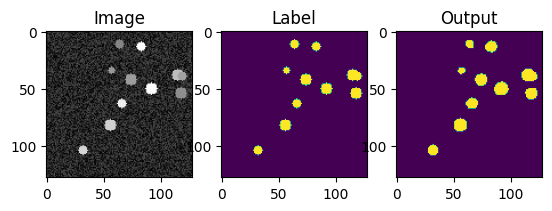



Noise = 0.6

----------
epoch 1/2
Loss: 0.8866 
Train dice: 0.4531
Test dice: 0.7671
Time: 4.0548
----------
epoch 2/2
Loss: 0.7029 
Train dice: 0.7755
Test dice: 0.8158
Time: 3.9277
Train completed, total time: 7.982882022857666.

Train metric = 0.7754596471786499, Test metric = 0.8157901763916016




<Figure size 640x480 with 0 Axes>

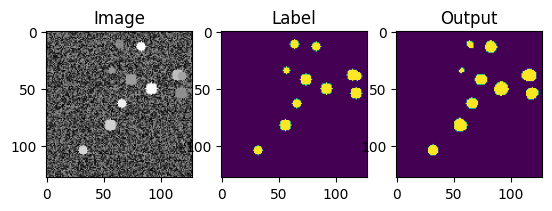



Noise = 0.9

----------
epoch 1/2
Loss: 0.9211 
Train dice: 0.2901
Test dice: 0.6912
Time: 3.2800
----------
epoch 2/2
Loss: 0.7408 
Train dice: 0.6656
Test dice: 0.7343
Time: 3.6163
Train completed, total time: 6.896320104598999.

Train metric = 0.6656080484390259, Test metric = 0.7342966198921204




<Figure size 640x480 with 0 Axes>

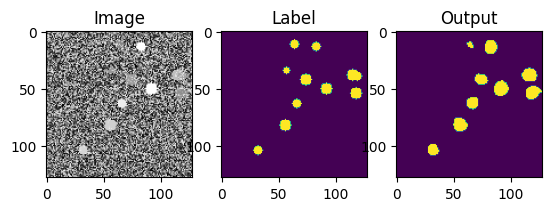



Noise = 1.2

----------
epoch 1/2
Loss: 0.9485 
Train dice: 0.2186
Test dice: 0.5064
Time: 3.4538
----------
epoch 2/2
Loss: 0.7712 
Train dice: 0.5630
Test dice: 0.6642
Time: 3.3098
Train completed, total time: 6.763701438903809.

Train metric = 0.5630009770393372, Test metric = 0.6641574501991272




<Figure size 640x480 with 0 Axes>

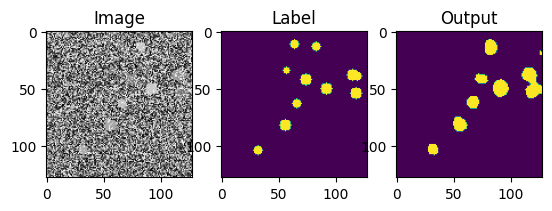



Noise = 1.5

----------
epoch 1/2
Loss: 0.9667 
Train dice: 0.1828
Test dice: 0.2538
Time: 4.3174
----------
epoch 2/2
Loss: 0.8298 
Train dice: 0.4266
Test dice: 0.5127
Time: 3.8221
Train completed, total time: 8.139525175094604.

Train metric = 0.42658519744873047, Test metric = 0.5127250552177429




<Figure size 640x480 with 0 Axes>

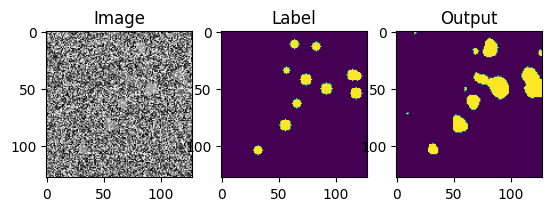



Noise = 1.8

----------
epoch 1/2
Loss: 0.9751 
Train dice: 0.1524
Test dice: 0.2610
Time: 4.5243
----------
epoch 2/2
Loss: 0.8524 
Train dice: 0.3642
Test dice: 0.5050
Time: 4.5217
Train completed, total time: 9.046075582504272.

Train metric = 0.364227831363678, Test metric = 0.5050380229949951




<Figure size 640x480 with 0 Axes>

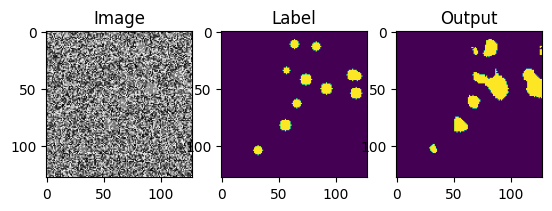



Noise = 2.1

----------
epoch 1/2
Loss: 0.9859 
Train dice: 0.1164
Test dice: 0.2471
Time: 3.2899
----------
epoch 2/2
Loss: 0.8917 
Train dice: 0.2934
Test dice: 0.4104
Time: 3.4183
Train completed, total time: 6.7082905769348145.

Train metric = 0.29335930943489075, Test metric = 0.41038838028907776




<Figure size 640x480 with 0 Axes>

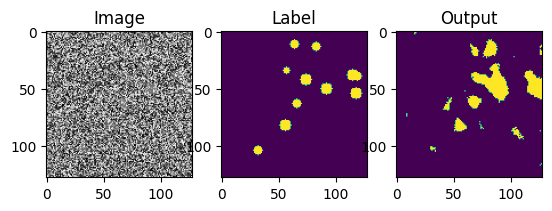

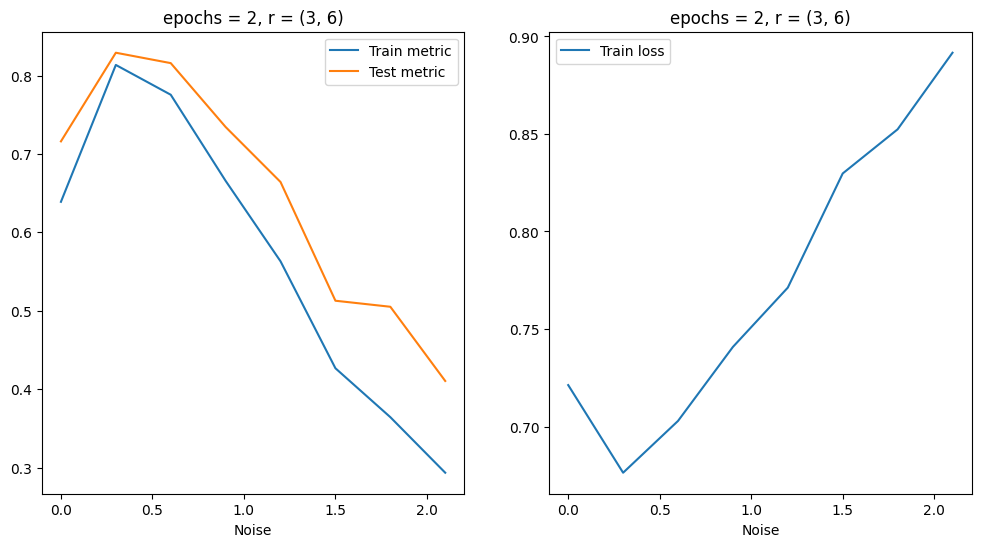

In [18]:
n_train = 60
n_test = 40

noise_vec = [0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1]
r_min = 3
r_max = 6

max_epochs = 25

metric_values_train_vec = []
metric_values_vec = []
epoch_loss_values_vec = []


for noise in noise_vec:
  print()
  print(f"Noise = {noise}")
  print()

  train_files, val_files = create_image_2d(n_train, n_test, noise, r_min, r_max)
  train_loader, val_loader, val_ds = transform(train_files, val_files)

  metric_value_train, metric_value, epoch_loss_value = model_and_train(train_loader, val_loader, max_epochs, val_ds)

  metric_values_train_vec.append(metric_value_train)
  metric_values_vec.append(metric_value)
  epoch_loss_values_vec.append(epoch_loss_value)

  delete_image(directory_path)

plot_noise(noise_vec, metric_values_train_vec, metric_values_vec, epoch_loss_values_vec, r_min, r_max, max_epochs)